# CMSC 422 Project 2: Unsupervised Learning

In this project, we will explore dimensionality reduction (PCA) and
clustering.

Files you'll edit:

    dr.py           Implementation of PCA
    clustering.py   Implementation of K-means (and variants)
    cifar10.py      Utilities to work with CIFAR10 data

Files you might want to look at:

    datasets.py     Some simple toy data sets
    digits          Digits data
    util.py         Utility functions, plotting, etc.

In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import datasets
import util
import dr as dr
import cifar10 as cifar10
import clustering as clustering
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Part 0: PCA (40%)

Our first tasks are to implement PCA.  If implemented correctly, these
should be 5-line functions (plus the supporting code I've provided):
just be sure to use numpy's eigenvalue computation code.  **Implement
PCA in the function `pca` in `dr.py`.**

Our first test of PCA will be on Gaussian data with a known covariance
matrix.  First, let's generate some data and see how it looks, and see
what the *sample covariance* is:

array([[2.72175347, 1.84343259],
       [1.84343259, 4.06097213]])

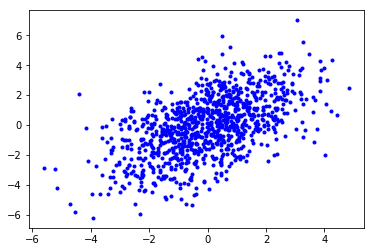

In [9]:
np.random.seed(422)

# Specify the sample covariance of the multivariate normal data
Si = util.sqrtm(np.array([[3,2],[2,4]]))
x = np.dot(np.random.randn(1000,2), Si)

plt.plot(x[:,0], x[:,1], 'b.')
np.dot(x.T,x) / np.real(x.shape[0])

In [10]:
x.sum(axis=1)

array([-4.82799746e+00, -7.01727704e-01,  1.39475686e+00,  2.26774024e+00,
        4.34014155e+00, -8.66789344e-01,  3.04774255e+00, -1.01025870e+01,
       -3.22974196e+00, -4.04518171e-01, -4.21621928e+00, -6.04095549e+00,
       -1.13523559e+00,  2.62191510e+00,  4.43811713e-01,  2.24110308e+00,
       -3.84756656e+00,  1.37231637e+00, -3.76801948e+00, -1.43994694e-01,
        3.16749015e+00,  6.08483559e-01, -4.21556856e+00,  1.20785256e+00,
       -1.31896512e+00,  2.30378470e-01, -1.61826075e+00, -4.37182396e+00,
       -7.44263849e+00,  6.84277695e-01, -5.12318720e+00,  5.98491290e+00,
        1.46931005e+00,  9.27739774e-01, -3.14213763e-01,  1.39943450e+00,
        1.16942967e+00,  3.68410320e-01, -3.11433604e-01, -1.22231526e+00,
        5.39063005e+00, -2.16245596e+00,  1.72252938e+00,  2.23681740e-01,
        8.78177984e+00, -6.02401840e+00,  2.15071585e-01, -4.60857691e+00,
       -6.92305357e+00,  1.09198624e+00, -2.43533356e+00, -1.26203540e+00,
       -1.19969038e+00, -

(Note: The reason we have to do a matrix square-root on the covariance
is because Gaussians are transformed by standard deviations, not by
covariances.)

Note that the sample covariance of the data is almost exactly the true
covariance of the data.  If you run this with 100,000 data points
(instead of 1000), you should get something even closer to
`[[3,2],[2,4]]`.

Now, let's run PCA on this data.  We basically know what should
happen, but let's make sure it happens anyway.

In [33]:
(P,Z,evals) = dr.pca(x, 2)
print('Z:', Z)
print('evals:', evals)


1
[[-1.87976624 -2.94823122]
 [ 0.47305884 -1.17478654]
 [ 0.39057983  1.00417703]
 ...
 [-1.95110852 -1.96993169]
 [-0.38978341  0.15050506]
 [-0.98831812  1.22407882]]
1
[1.43149656 5.3528064 ]
[[-0.8189231  -0.57390327]
 [ 0.57390327 -0.8189231 ]]
2
[5.3528064  1.43149656]
[[-0.57390327 -0.8189231 ]
 [-0.8189231   0.57390327]]
3
[[ 3.42114065 -0.14843527]
 [ 0.61853184 -1.05743238]
 [-1.11853678  0.26062591]
 ...
 [ 2.66093214  0.47143787]
 [ 0.02840792  0.40975825]
 [-0.5072654   1.51603964]]
1000
2
1000
Z: [[-0.8189231   0.57390327]
 [-0.57390327 -0.8189231 ]]
evals: [5.3528064  1.43149656]


This tells us that the largest eigenvalue corresponds to the
direction `[ 0.57390327  0.8189231 ]` and the second largest corresponds to
the direction `[-0.8189231   0.57390327]`.  We can project the data onto
the first eigenvalue and plot it in red, and the second eigenvalue in
green.  (Unfortunately we have to do some ugly reshaping to get
dimensions to match up.)

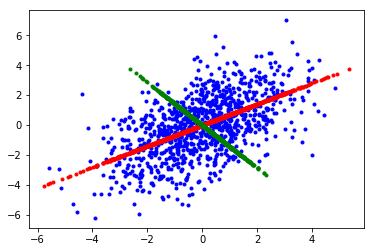

In [34]:
x0 = np.dot(np.dot(x, Z[:,0]).reshape(1000,1), Z[:,0].reshape(1,2))
x1 = np.dot(np.dot(x, Z[:,1]).reshape(1000,1), Z[:,1].reshape(1,2))
plt.plot(x[:,0], x[:,1], 'b.', x0[:,0], x0[:,1], 'r.', x1[:,0], x1[:,1], 'g.')

## PCA on a "real" example - CIFAR10

Now, let's look at some "real" data, we have preprocessed some data from [CIFAR](https://www.cs.toronto.edu/~kriz/cifar.html) for you. We have extracted 2000 16x16 images from the CIFAR10 dataset and have supplied the dataset to you in the form of a [pickled](https://docs.python.org/3.1/library/pickle.html) python dictionary whose keys correspond to the following:
    - 'X' : List with shape (2000, 784) corresponding to the 2000 CIFAR10 images
    - 'y' : The labels corresponding to images in X. The labels 0-9 corrspond to the categories, 
        `[airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck]`.

First, **implement `cifar10.load_data(...)`, so we can easily get load and use pickled data.** We can then take a look at some examples of the data. Fun!

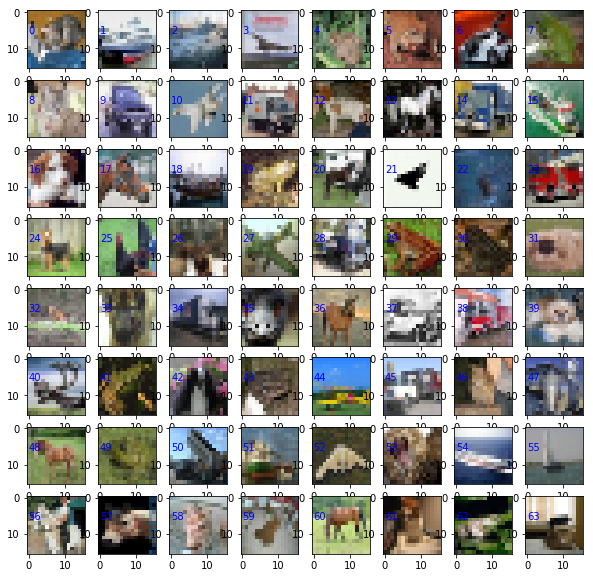

In [38]:
(X,y) = cifar10.load_data('data/cifar10.pkl')
cifar10.show_imgs(X[:64])

In [37]:
X

array([[158, 165, 160, ..., 197, 164, 126],
       [235, 232, 232, ..., 138, 164, 196],
       [158, 139, 166, ...,  45,  54,   3],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [ 52,  88,  87, ..., 253, 240,  57],
       [222, 220, 220, ..., 246, 239, 251]])

Let's apply PCA to our data and see what we find...

In [36]:
(P,Z,evals) = dr.pca(X, X.shape[-1])

1
[[158 165 160 ... 197 164 126]
 [235 232 232 ... 138 164 196]
 [158 139 166 ...  45  54   3]
 ...
 [255 255 255 ... 255 255 255]
 [ 52  88  87 ... 253 240  57]
 [222 220 220 ... 246 239 251]]
1
[9.40244239e+05 3.25164360e+05 2.05388395e+05 1.20104113e+05
 1.08807321e+05 8.63337282e+04 7.94729339e+04 6.72890463e+04
 6.10224730e+04 4.61483199e+04 4.18179049e+04 3.54004614e+04
 3.29726368e+04 3.15839396e+04 2.89525400e+04 2.50979640e+04
 2.32289059e+04 2.29296429e+04 2.18249479e+04 2.12810869e+04
 2.01675335e+04 1.91301950e+04 1.66026653e+04 1.57365950e+04
 1.52991288e+04 1.50256343e+04 1.45716826e+04 1.43594033e+04
 1.28174218e+04 1.25818079e+04 1.17756867e+04 1.10685623e+04
 1.03133381e+04 1.02352394e+04 9.89950020e+03 9.47877398e+03
 9.03162516e+03 8.45375895e+03 8.32431196e+03 8.15824134e+03
 7.83827999e+03 7.61871343e+03 7.20083413e+03 7.10145442e+03
 6.85281840e+03 6.59360487e+03 6.44999858e+03 6.29637756e+03
 6.20981508e+03 6.01625404e+03 5.91145193e+03 5.78994687e+03
 5.69278384

**Q1:** **Plot** the explained variance when you include up to $n$ eigenvectors for each possible value of $n$. How many eigenvectors do you have to include before you've accounted for 90% of the variance?  95%? (Hint: see function
`cumsum`.) 

In [ ]:
### Produce your plot here

**A1:** (Answer here)

Something interesting that we can do is to actually visualize the top eigenvectors. You will have to first implement `cifar10.normalize_img(...)`.

Let's plot the top 64 eigenvectors:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(768, 768)
[[ 0.02104934 -0.03136202 -0.02344264]
 [-0.00648198 -0.0468856   0.01862239]
 [ 0.00448649 -0.01380197  0.00010111]
 [-0.00278985 -0.02855516 -0.04638549]
 [ 0.00617126  0.04283702  0.01510686]
 [ 0.01566995 -0.02698696 -0.02114625]
 [-0.01163241  0.00110449 -0.00324277]
 [-0.05520543 -0.04924866 -0.01818684]
 [ 0.02191872  0.0016432  -0.02898738]
 [ 0.00781161 -0.01812678 -0.03271104]
 [-0.03003218  0.03857228 -0.0344939 ]
 [-0.01238473 -0.02833119  0.08462604]
 [ 0.00282125 -0.02577968 -0.00740758]
 [ 0.00948925  0.06559093 -0.05456681]
 [ 0.03112983  0.08805775  0.03396139]
 [ 0.02340076  0.03992231 -0.01009581]]
[[-0.03257177  0.01695359 -0.09530712]
 [ 0.02709689  0.02500722 -0.05358298]
 [-0.00305381 -0.03273615  0.02979551]
 [ 0.04170592 -0.05910752  0.03966498]
 [-0.02389674  0.00411422 -0.01774089]
 [-0.00687882 -0.00745995 -0.03992406]
 [-0.00803285 -0.00403923 -0.04658156]
 [ 0.06351614 -0.05160408 -0.01216645]
 [-0.03515762 -0.08256485  0.00793848]
 [ 0.02555754

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[ 0.01861042  0.03578942  0.00584778]
 [ 0.03827743 -0.00092298  0.00700476]
 [ 0.03175566 -0.01560998 -0.0166902 ]
 [ 0.04762711  0.05882119  0.02306463]
 [ 0.00431405 -0.02656242  0.06848504]
 [ 0.03453303 -0.02363643 -0.00414075]
 [-0.05571533  0.0331058   0.00235915]
 [-0.05510421  0.0368861  -0.01059873]
 [-0.03997833 -0.01682164  0.00766799]
 [-0.04269671 -0.02615378  0.03155647]
 [ 0.00401281  0.04106294 -0.00638687]
 [-0.01866157  0.06964224  0.02690302]
 [ 0.09410741  0.01476614 -0.02364792]
 [ 0.06588025 -0.04927926  0.02804298]
 [ 0.02071018  0.00706395 -0.01611644]
 [-0.03238183  0.04273029  0.02761626]]
[[ 0.00187603  0.01265213 -0.03020537]
 [-0.03194955  0.05192204  0.08584219]
 [-0.0722914  -0.00564127 -0.02879361]
 [ 0.01593864 -0.02695131  0.00147558]
 [ 0.07963942  0.04272432  0.06217949]
 [-0.01092674 -0.04269162 -0.05205289]
 [ 0.03260081  0.0384441  -0.00957323]
 [ 0.02323508  0.07686858  0.02006171]
 [-0.01580054  0.03590038  0.01852186]
 [ 0.08411186  0.0118060

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[ 0.05894469  0.00936635 -0.08533405]
 [ 0.00416582 -0.03451594 -0.05048218]
 [-0.01168975 -0.028562   -0.02087556]
 [ 0.02759594  0.04218974  0.06617961]
 [-0.02102016  0.04243657 -0.06477279]
 [ 0.01001867 -0.0407825   0.02455023]
 [ 0.01462265  0.00552904  0.03280625]
 [ 0.02696868 -0.00809085 -0.00048308]
 [-0.03766347 -0.00854314  0.01767859]
 [ 0.02032085 -0.00720025  0.01144831]
 [-0.02557226 -0.04216846 -0.06403545]
 [-0.00622533  0.0270089   0.00503021]
 [-0.02819913  0.03805937  0.00905737]
 [ 0.04456311 -0.05133527 -0.03511448]
 [ 0.00087384  0.03919685  0.01869655]
 [ 0.01710403  0.00441212 -0.01536117]]
[[-0.00271534 -0.01636478 -0.01895494]
 [ 0.06059098  0.02379604 -0.02363944]
 [ 0.01448154  0.01964267 -0.02437476]
 [-0.0203768   0.05349957 -0.04587101]
 [-0.02600608  0.07594407  0.0332439 ]
 [-0.05854023 -0.04589682 -0.01036807]
 [-0.02563252 -0.00534088 -0.02625611]
 [-0.05188737 -0.04116982  0.04852202]
 [-0.01537358 -0.01495736  0.03600788]
 [-0.00058107 -0.0032867

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[[ 0.01144589  0.01401866  0.05205145]
 [ 0.06286019  0.09875893  0.0390238 ]
 [-0.00319591 -0.00197426  0.01322589]
 [ 0.03154105 -0.04784855 -0.05300461]
 [-0.0054589  -0.01449561 -0.01793639]
 [-0.01126801 -0.0313006   0.02490743]
 [-0.06649185 -0.01276759 -0.05726782]
 [ 0.00330863  0.02605667  0.05363541]
 [-0.01758972  0.00618635 -0.01110372]
 [-0.05871551 -0.05163489 -0.0737229 ]
 [ 0.11287076 -0.03350978 -0.00562045]
 [ 0.01017532 -0.05879611 -0.03776437]
 [ 0.01318794 -0.04746459  0.02709404]
 [-0.05431477  0.02027823 -0.04191265]
 [-0.00316117 -0.01861258 -0.02397926]
 [ 0.03029835  0.03189908 -0.02810759]]
[[-0.00575852 -0.06250379  0.01525483]
 [ 0.01999987 -0.03211577 -0.01876617]
 [-0.01861041  0.01430457 -0.00328108]
 [ 0.04004796  0.07684028  0.03000022]
 [-0.01235467 -0.02496213 -0.0671875 ]
 [-0.03320428  0.01399255  0.02138646]
 [-0.00996228 -0.0130112  -0.01146808]
 [ 0.0220912  -0.01652939  0.01120431]
 [ 0.03243582  0.02074114  0.11753978]
 [ 0.0076145   0.0181581

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i


[[-0.02998036 -0.03075368 -0.01635609]
 [ 0.03949478 -0.06409033  0.04407454]
 [ 0.01905783  0.0003954   0.07215704]
 [ 0.00867594 -0.00745389 -0.02219415]
 [-0.01324387 -0.00445438 -0.00187846]
 [ 0.00979814  0.05957818  0.00301118]
 [-0.08920149 -0.01061879  0.03358188]
 [-0.01963967  0.09510907  0.00287665]
 [ 0.02500141  0.01589591 -0.01429378]
 [ 0.03039355 -0.00576676 -0.00757716]
 [-0.06940228 -0.0572871   0.02649051]
 [-0.01311438  0.01782181 -0.06527524]
 [ 0.02565212 -0.00871632  0.03780821]
 [ 0.00440481  0.01061972  0.00435789]
 [ 0.05501533  0.0255491  -0.01145663]
 [ 0.02515281 -0.02554359  0.004199  ]]
[[-0.00806862  0.01942857  0.0110319 ]
 [-0.00763121 -0.03673388 -0.01572286]
 [-0.0229807  -0.01070702 -0.01834203]
 [ 0.04788822  0.01883956 -0.05510076]
 [-0.02589811  0.00169317 -0.01554335]
 [ 0.05238363  0.08486329  0.03035611]
 [ 0.0338168   0.00441687 -0.01012659]
 [-0.01812265 -0.0567659  -0.02510393]
 [ 0.05421261 -0.01436069 -0.01384364]
 [ 0.02765746 -0.021723

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[ 0.06889929 -0.02313098  0.05310312]
 [ 0.04720763 -0.05200164 -0.01295356]
 [-0.03339153 -0.02674887  0.01971416]
 [-0.00810135 -0.03165561  0.03947474]
 [ 0.00793485  0.00978066  0.00158962]
 [ 0.02949921  0.02910511  0.01816724]
 [-0.02300199  0.01436831 -0.06358436]
 [ 0.04552928  0.0300527   0.05664438]
 [ 0.01019787 -0.02947942 -0.03916435]
 [ 0.02679048  0.00438573 -0.02367834]
 [ 0.08099441  0.0052838  -0.02378811]
 [ 0.05609736  0.03022387 -0.09197284]
 [-0.02725893  0.03154408 -0.07678883]
 [-0.02657207 -0.05264551 -0.00591987]
 [-0.00992946  0.00268885 -0.03880018]
 [ 0.0398825  -0.0222408  -0.03069378]]
[[-3.09076192e-02  4.20324776e-02 -7.80475959e-03]
 [-6.34574373e-02  3.71848932e-02  3.97890251e-02]
 [-8.84527195e-03  4.73479286e-02 -5.98614522e-03]
 [ 1.19430021e-02  3.96263061e-02  3.49208716e-02]
 [-4.47926128e-02  5.20271108e-02 -2.36739967e-02]
 [ 2.51583785e-02 -1.59213556e-02 -1.51135764e-02]
 [ 5.34035309e-02 -2.43427584e-05 -2.15264873e-02]
 [ 1.28861561e-02 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i


[[ 0.01981574  0.00277568  0.04084953]
 [-0.0372163  -0.01439892  0.02009587]
 [-0.0053219   0.00265537 -0.00818252]
 [ 0.00384212  0.00119699 -0.05415809]
 [ 0.03185027  0.02417209 -0.00049066]
 [ 0.02257232  0.00064252  0.00698814]
 [ 0.02126183 -0.00891117  0.04629709]
 [ 0.00984855 -0.01065013 -0.00482559]
 [-0.0063448  -0.04556808 -0.03921291]
 [ 0.00593839 -0.01657628 -0.02590237]
 [-0.05639276 -0.02196485  0.04736419]
 [ 0.0397112   0.00685052 -0.0695537 ]
 [ 0.0207371  -0.04416249  0.06376114]
 [ 0.00123161  0.00276222  0.0344084 ]
 [-0.03064613 -0.03091507  0.00536064]
 [-0.01510083  0.02492129  0.0001232 ]]
[[ 0.05035609  0.00486164 -0.00621749]
 [ 0.01325744 -0.08581557 -0.06827258]
 [ 0.01706549  0.01847163 -0.02628629]
 [-0.00171804 -0.00584686 -0.01632892]
 [ 0.02513564 -0.01579556 -0.03488223]
 [-0.01358904  0.00663972 -0.03082651]
 [ 0.02920474 -0.02009312  0.03514317]
 [ 0.01891345  0.05241447  0.03311249]
 [-0.01301126  0.02710026  0.06672604]
 [ 0.08306511 -0.008023

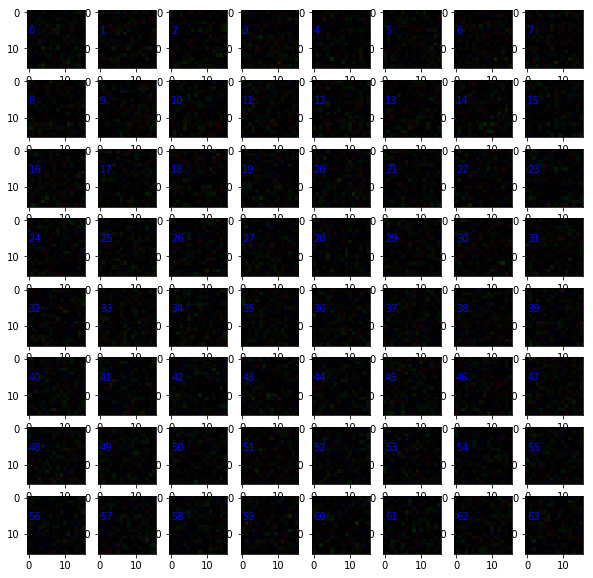

In [40]:
print(Z.shape)
cifar10.show_imgs(Z.T[:64], normalize=True)

**Q2:** Why do we need to normalize the values in the eigenimages when we want to visualize them? What would happen if we did not?

**A2:**

**Q3:** Do these eigenimages look like images?  Should they?  Do these look like parts of images? Should they? Why or why not?

**A3:**

Lets take a closer look at two particular images...

In [ ]:
i = 10
n_pcs = 8
img = X[i]
pcs = P[i]
pc_order = np.argsort(-np.abs(pcs))[:n_pcs]
cifar10.show_img(img)
print("Principal components, sorted:", pc_order)
cifar10.show_imgs(Z.T[pc_order][:n_pcs], normalize=True)
print("*" * 20)
i = 55
img = X[i]
pcs = P[i]
pc_order = np.argsort(-np.abs(pcs))[:n_pcs]
cifar10.show_img(img)
print("Principal components, sorted:", pc_order)
cifar10.show_imgs(Z.T[pc_order][:10], labels=pc_order[:], normalize=True)

**Q4:** Look at the image above, look carefully at the principal components 0, 1, and 2. How do these relate to the above two images? Why do these principal components make sense (hint: say some thing about how most of the images in the dataset are composed/look like)?

**A4:**

# Part 1: K-means clustering (40%)

Your second task is to implement the largest distance heuristic for
kmeans clustering in `clustering.py`.

Note that we have already implemented the first initialization heuristic, the *deterministic* heuristic, where the initial K means are simply the first K data points the algorithm recieves. You will have to **implement `clustering.kmeans(...)`**.

Then we can quickly run through some basic experiments k-means:

**Hint:** While running, this will plot the results.  If you want
to turn that off, comment out the obvious line in the `kmeans`
function.  Plus, when it says "Press enter to continue", if you type
"q" and press enter, it will stop bugging you.

In [ ]:
mu0 = clustering.initialize_clusters(datasets.X2d, 2, 'determ')
(mu,z,obj) = clustering.kmeans(datasets.X2d, mu0)
print('mu', mu)
print('z', z)
print('obj', obj)

You can also play with another example:

In [ ]:
mu0 = clustering.initialize_clusters(datasets.X2d2, 4, 'determ')
(mu,z,obj) = clustering.kmeans(datasets.X2d2, mu0)

Now **implement the furthest first heuristic (`ffh`)**, and we can use this heuristic with K-means to cluster the CIFAR10 data.

In [ ]:
mu0 = clustering.initialize_clusters(X, 15, 'ffh')
(mu,z,obj) = clustering.kmeans(X, mu0, doPlot=False, verbose=False)

**Q5:** **Make a plot** of the K-means objective against iteration number. Why does the plot have a long tail? Why do we expect the plot to have this shape?

In [ ]:
# Make your plot here
### TODO: YOUR CODE HERE

**A5:**

Lets see if we can visualize the clusters...

In [ ]:
util.plotDatasetClusters(X[:,:2], mu[:, :2], z)

**Q6:** Why don't we see clear clusters here? what did we do wrong?

**A7:**

Lets do something better then!

In [ ]:
util.plotDatasetClusters(P[:,:2], mu[:, :2], z)

**Q7:** Is this plot better? Why does plotting the images using the first two PCs make sense? Qualitatively, what can we say about the clusters?

(Note: If you are having a hard time seeing the colors/clusters, please ask the instructors for more assistance.)

**A7:**

# Evaluating K-means (20%)

**Now implement the `km++` (K Means++), and `random` heuristics**

**Q8:** **Run kmeans 5 times each** with 15 centroids for the kmeans++, furthest first, and random selection, heuristics. For each heuristic, **answer and do** the following.
- For each heuristic, plot **one** plot of iteration against objective. (Each plot should have 5 lines).
- What was the average number of iterations it took for k-means to converge
- Which was the best heuristic?

In [ ]:
### TODO: YOUR CODE FOR Q7 HERE. Insert cells for different runs and answers as appropriate

**A8:**

**Q9:** Out of all your runs, select your "best" run (the run with the lowest objective) and, for the clustering from the best run, report the following:
- For each cluster:
    - 1) Report the modal class
    - 2) Report the percentage of the cluster that is the modal class
    - 3) Display 20 (a 2x10 grid) of sample points from the cluster
    - 4) Display the cluster mean
    - 5) Describe the cluster using one or two sentences.
- **Hint:**, for each fold, your output for 1-4) might look like:
<img src="kmeans_example_analysis.PNG" width="400">

In [ ]:
### YOUR CODE HERE FOR Q8

**A9:**

**Q10:**
- How successful was the clustering? Write a paragraph (5-7 sentences) describing how 
- Look at your sample images from your clusters and your cluster centroids, you should see a cluster whose modal label is airplane or boat (look for the cluster mean that vaguely looks like an object in the sky/ocean). Is this a good cluster? Why is it a good cluster? Why are both images of planes and boats in this cluster; how did kmeans get confused? What did kmeans "learn" (what features of the image did the algorithm pick up on)? Why might confusing images of boats and planes be problematic?

**A10:**

# Extra Credit! - "Really" evaluating K-means...

The CIFAR10 dataset that we have provided you is nice to play with because we have ground truth labels. However, in the real world, we don't use unsupervised learning on labeled datasets. For extra credit, try the some of the following:

- Without CIFAR10 labels, can you try to find out how many clusters or classes of images there really are? Try K-means clustering with different Ks and evaluate your result by implementing a metric like [silhuotte width](https://en.wikipedia.org/wiki/Silhouette_(clustering)). What patterns do you find, are there "subclasses" of classes in the dataset? Are there other patterns in the dataset other than just the 10 classes? Are the clusters any good? Can you use other featurizations or dimention reduction algorithms (like PCA) to improve your clustering? Why do they work?

- Or, find or generate an unlabeled dataset, perform dimention reduction and clustering and evaluate your findings.

Just show us that you have learned something new and attempt to apply the new things you have learned! Have fun.